In [61]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit ,transpile
from qiskit_aer import AerSimulator
from itertools import product
from qiskit_aer import Aer

# In this implemention,
1. Encode mxnx3(RGB) image into mxn('Black and white') image using modular arithmetic
2. We encoded a mxn image using N=⌈log2(W×H)⌉ qubits.
3. Teleport the encoded state.
4. Decode the state.


# 1. Classical Encoding
The function takes in an image with shape (w, h,3) or (w, h) and encodes it using modular arithmetic.
First, the function checks the number of dimensions of the input image. If the image has 3 dimensions, it means that it is an RGB image with shape (w, h, 3), where the first dimension corresponds to the red (r), green (g), and blue (b) channels, and the next two dimensions correspond to the width and height of the image.
In this case, the red, green, and blue channels are extracted from the image using image[:,:,0], image[:,:,1], and image[:,:,2] respectively.

If the image has only 1 dimension, it is assumed to be a grayscale image with shape (w, h), and the red, green, and blue channels are set to the grayscale values of the image.
Next, the function computes the modular encoded image by performing the following operation:
modular_image = (r*M*N) + (g*N) + b /n

where r, g, and b are the red, green, and blue channels of the image, and M and N are the modular bases provided as input to the function.

The resulting modular_image is a 2-dimensional array with shape (w, h) representing the modular encoded RGB image

After, modular_image is rounded to the nearest integer using np.round, ensuring that the pixel values are whole numbers.
Finally, the data type of modular_image is converted to integer using .astype(int).

# 2. Amplitude encoding of modular encoded image
For amplitude encoding, 'amplitude_encode' function begins by determining the total number of quantum states, which corresponds to 2^num_qubits states for a system with num_qubits qubits. The image data is normalized by dividing each pixel value by the maximum pixel value, ensuring that all values fall within the range [0, 1]. Each normalized pixel value is squared, and the sum of these squares yields a measure of the total energy or "brightness" of the image. Normalizing this vector by taking its square root ensures that the sum of squares of the amplitudes equals 1, a requirement for a valid quantum state. The resulting normalized pixel values are divided by the square root of the sum to obtain the amplitudes of the quantum state, represented by the vector temp. This vector is reshaped into a column vector, forming the amplitude-encoded image. If there is a discrepancy between the total number of quantum states and the number of pixels in the image, additional zeros are appended to the amplitude-encoded image vector to match the total number of states. This process ensures that the quantum state is appropriately represented within the full Hilbert space. 

As a result, we have a column vector (or a column array) with amplitudes that eventually will be assigned to the quantum states. Our goal to teleport those amplitudes, decode them and reconstruct to obtain the original image.


# 3. TELEPORTATION
The 8-channel state teleportation channel was greatly inspired by https://www.columbia.edu/~ask2262/CourseProjects/Kudinoor_n-QubitQuantumTeleportationProtocol.pdf. We simple reconstructed the entangled state of 8-qubits in the paper for our protocol.

Our goal is to get exactly the teleported amplitudes that are stored in last num_qubits qubits(bob_channel_register).
On this step, we encountered a few challenges: first was that the probabilities after execution were not sorted. For example, instead of getting the probability of |0000 0000 0000> in first index, it was at a different index. So, in order to process results, we sorted them.

However, it is not the end. As we mentioned previously, we are only interested in class_state channels. So, from |0000 0000 0000> measurement we are only interested in digits at index 0,1,2,3 as these represent the measurement values of the last 4 qubits.

Finally, we created a new sorted_statistics, where a list of basis states iterated and the total counts (measurements) are calculated for each basis state from the previously obtained sorted_statistics dictionary.

# 4 Classical Decoding + Reconstruction of Image
This begins by computing the amplitudes from the total counts of each basis state, which are derived from the sorted_statistics2 dictionary. These amplitudes are then normalized to probabilities, ensuring they adhere to the principles of quantum mechanics by summing up to unity. The probabilities are subsequently used to reconstruct the image, with additional scaling factors such as the root mean square (RMS) value of the original image and the maximum pixel value (img_max) applied to maintain the statistical properties of the image. Following reconstruction, the pixel values are rounded to the nearest integer and converted to the appropriate data type for image representation. Finally, the reconstructed image is obtained through classical decoding, effectively reversing the modular encoding applied to the original image.

<div><img width="574" alt="image" src="/workspaces/QC/qc_output.png"></div>
The images are arranged in the following order: Original (initial), Modular (Normalized/Encoded, before Teleportation), Decoded (Almost exactly the same as Modular, after Teleportation), Reconstructed (Final, but not exactly the same as initial one). 


In [62]:
def classical_encode(image, M:int =349, N:int =351):
    """
    Classical encode an RGB image into a single-channel image using modular arithmetic.

    Parameters:
    - image (ndarray): Array of RGB data of shape (3, w, h).
    - M (int): First modular base.
    - N (int): Second modular base.

    Returns:
    - ndarray: Array of modular encoded RGB image of shape (w, h).
    """
    image_dim = len(image.shape)
    if image_dim == 3:
        r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    elif image_dim == 1:
        r, g, b = image[0], image[1], image[2]

    modular_image = (r * M * N) + (g * N) + b
    print("Shape of classical modular encoded image is", modular_image.shape)
    print(f"Positions of zero valued pixels in original image {np.where(image==0)}")
    return modular_image


def classical_decode(modular_image, M:int=349, N:int=351):
    """
    Decode a modular encoded image back to its original RGB representation.

    Parameters:
    - modular_image (ndarray): Array of modular encoded image.
    - M (int): First modular base.
    - N (int): Second modular base.

    Returns:
    - ndarray: Reconstructed RGB image from the modular_image.
    """
    b = modular_image % N
    g = (modular_image // N) % M
    r = (modular_image // (M * N)) % M
    print(np.where(r == 0))
    print(np.where(g == 0))
    print(np.where(b == 0))
    reconstructed_image = np.stack((r, g, b), axis=0)
    reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))
    return reconstructed_image


def get_qubits(image_width, image_height):
    """
    Calculate the number of qubits required to represent an image.

    Parameters:
    - image_width (int): Width of the image.
    - image_height (int): Height of the image.

    Returns:
    - int: Number of qubits required.
    """
    num_qubits = np.log2(image_width * image_height)
    if num_qubits % 1 == 0:
        return int(num_qubits)
    else:
        num_qubits = np.ceil(np.log2(image_width * image_height))
        return int(num_qubits)


def amplitude_encode(img_data, num_qubits):
    """
    Encode an image into an amplitude-encoded quantum state.

    Parameters:
    - img_data (ndarray): Image data as a numpy array.
    - num_qubits (int): Number of qubits to use for encoding.

    Returns:
    - ndarray: Amplitude-encoded image as a flattened array.
    - float: Square root of the sum of squared pixel values.
    - int: Number of pixels in the image.
    - float: Maximum pixel value in the image.
    """
    total_states = 2**num_qubits
    img_w, img_h = img_data.shape[0], img_data.shape[1]
    pixel_num = img_w * img_h
    img_max = np.max(img_data)
    norm_img = img_data / img_max
    norm_sq = norm_img**2
    norm_sq_sum = np.sum(np.sum(norm_sq, axis=1))
    norm_sq_sum_root = np.sqrt(norm_sq_sum)
    temp = norm_img / norm_sq_sum_root
    amplitude_encoded_image = temp.reshape(pixel_num, 1)
    print("Sum of pixel values to initialize qubits to sum to:", np.sum(temp**2))

    # appends zeros to the amplitude_encode_image vector if the basis for num_qubits > pixel_num. This is to prevent errors from the code.
    states_pixel_difference = total_states - pixel_num
    if states_pixel_difference != 0:
        zeros_to_append = np.zeros((states_pixel_difference, 1))
        amplitude_encoded_image = np.vstack((amplitude_encoded_image, zeros_to_append))

    print("Shape of amplitude encoded image=", amplitude_encoded_image.shape)
    print("Total number of basis state=", total_states)
    print("Number of zeros to append=", states_pixel_difference)
    return amplitude_encoded_image.reshape(int(total_states)), norm_sq_sum_root, pixel_num, img_max


def get_basis_states(num_qubits):
    """
    Generate all possible basis states for a given number of qubits.

    Parameters:
    - num_qubits (int): Number of qubits.

    Returns:
    - list: List of basis states as binary strings.
    """
    combinations = list(product([0, 1], repeat=num_qubits))
    basis_states = []
    for combination in combinations:
        basis_states.append(''.join(filter(str.isdigit, str(combination))))
    return basis_states


Shape of original image: (4, 4, 3)
Shape of classical modular encoded image is (4, 4)
Positions of zero valued pixels in original image (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
Number of qubits to initialise is:4
Sum of pixel values to initialize qubits to sum to: 1.0
Shape of amplitude encoded image= (16, 1)
Total number of basis state= 16
Number of zeros to append= 0


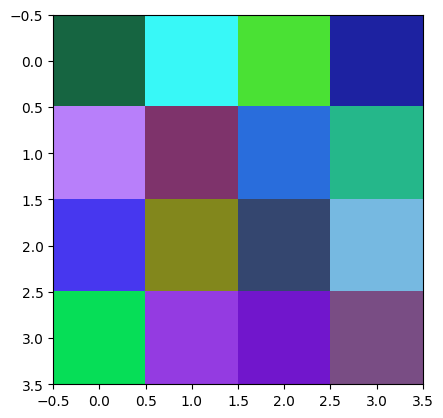

In [63]:
image_width = 4
image_height = 4
M=300
N=300

image = np.random.randint(1, 255, size=3*image_width*image_height).reshape(image_width, image_height,3)
#image = image/np.max(image)

print("Shape of original image:", image.shape)
plt.imshow(image)

# ENCODE RGB IMAGE TO 1-CHANNEL MXN IMAGE
modular_image = classical_encode(image, M=M, N=N)
modular_image = np.round(modular_image)
modular_image = modular_image.astype(int)

# GETS THE NUMBER OF QUBITS NEEDED FROM.
num_qubits = get_qubits(image_width=image_width, image_height=image_height)
print(f"Number of qubits to initialise is:{num_qubits}")

# COVERTS modular_image TO A VALID STATE VECTOR.
amplitude_encoded, rms, pixel_num, img_max = amplitude_encode(modular_image, num_qubits=num_qubits)

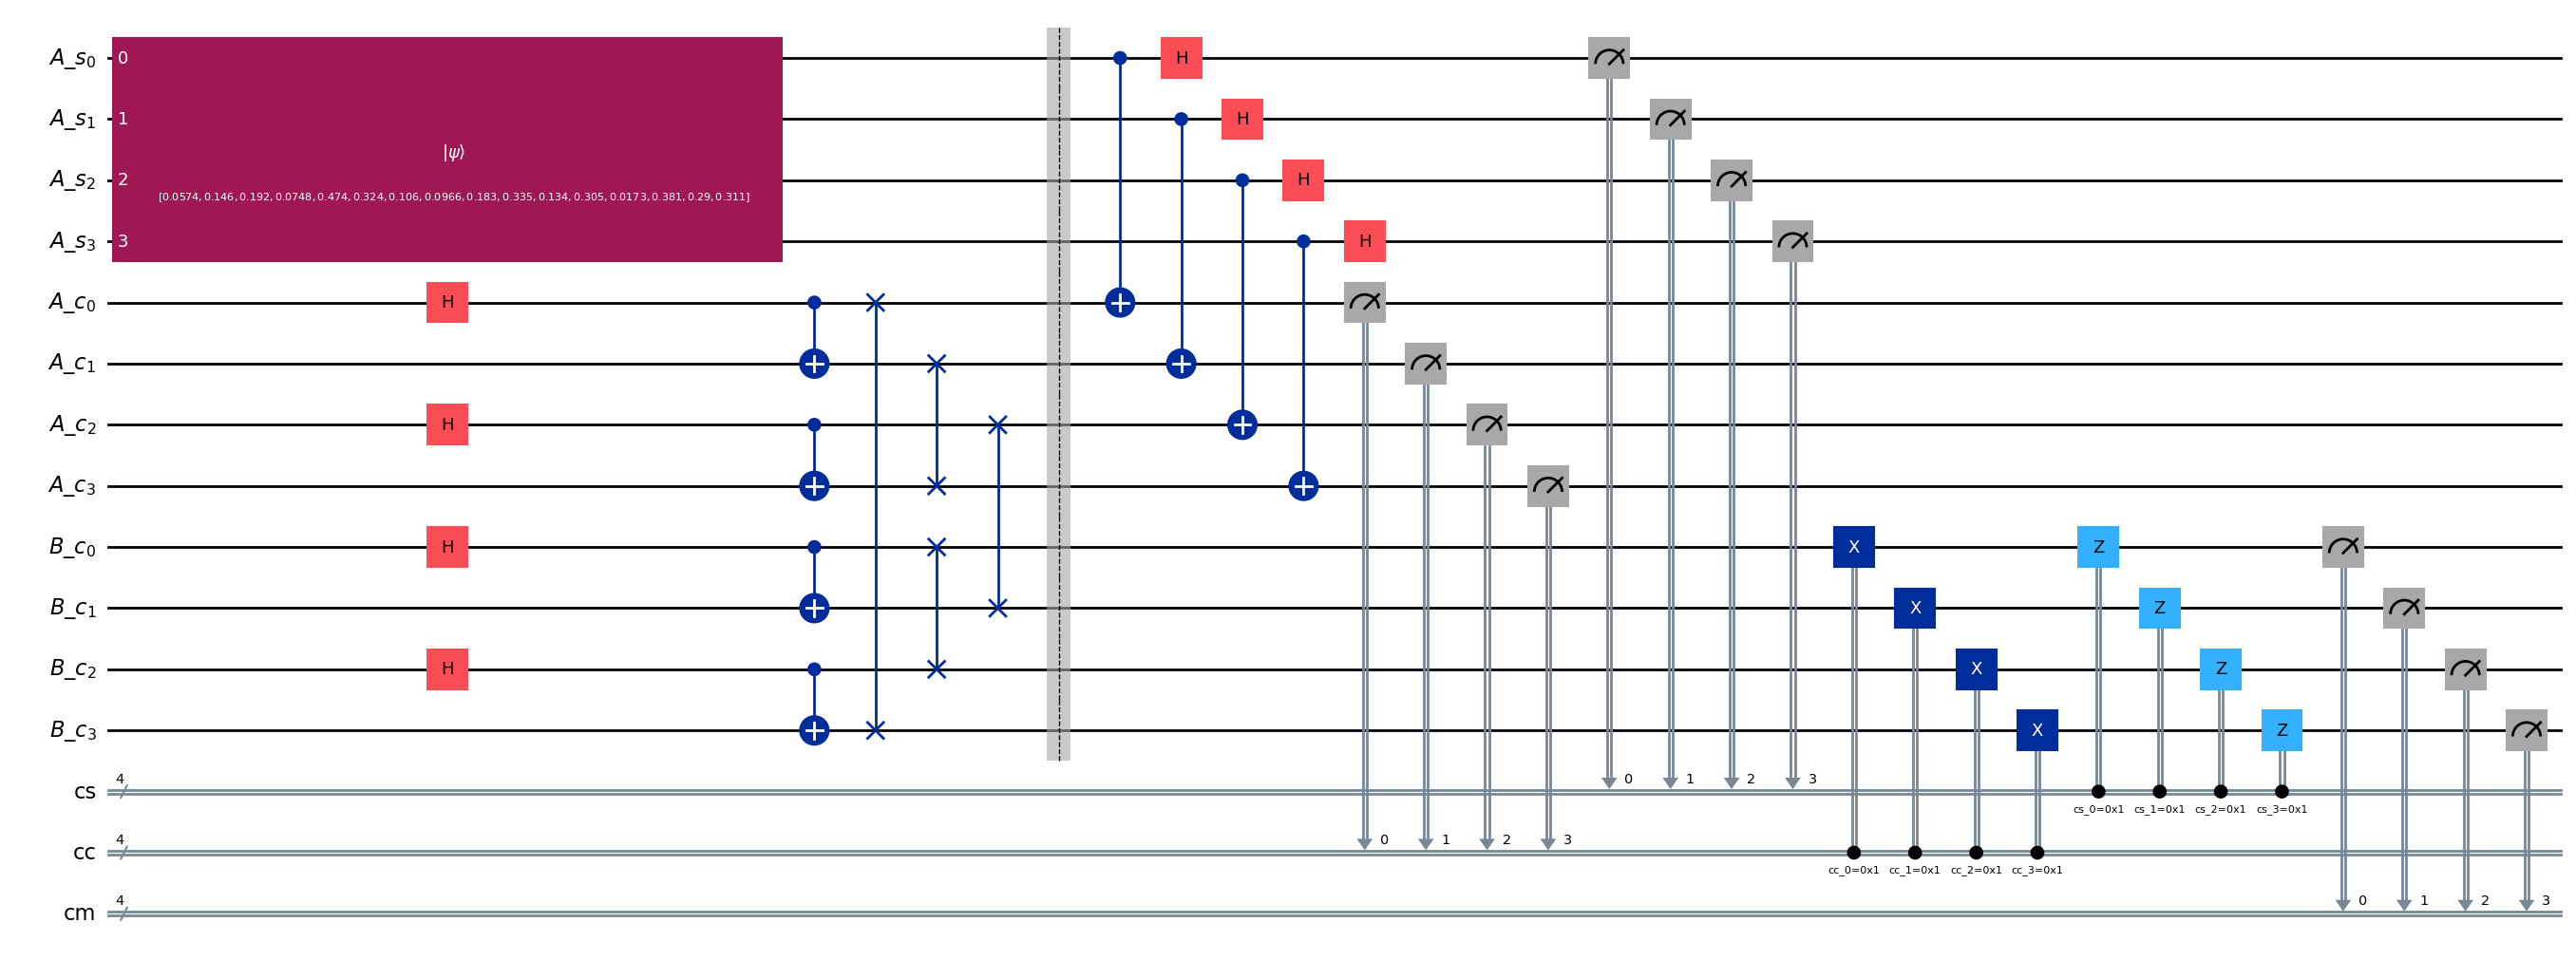

In [64]:
num_channel_state_qubits = num_qubits*2

alice_state_register = QuantumRegister(num_qubits, 'A_s') # Qubits to store the state of image(state to be teleported)

# alice_channel_register and bob_channel_register form an entangled channel state. alice_channel_register denotes the portion of the entangled state with Alice and bob_channel_register likewiuse
alice_channel_register = QuantumRegister(num_qubits, 'A_c') 
bob_channel_register = QuantumRegister(num_qubits, 'B_c')

classical_state = ClassicalRegister(num_qubits, 'cs') # store measurements from the encoded state
classical_channel = ClassicalRegister(num_qubits, 'cc') # store measurements from alice_channel_register
classical_measure = ClassicalRegister(num_qubits, 'cm') # store measurements from bob_channel_register

qc= QuantumCircuit(alice_state_register,alice_channel_register, bob_channel_register, classical_state, classical_channel, classical_measure)

qc.initialize(amplitude_encoded, range(0, num_qubits)) # INITIALISE QUANTUM CIRCUIT TO THE VALID VECTOR STATE(amplitude_endoded)
qc.h([num_qubits, num_qubits+2, num_qubits+4, num_qubits+6])
qc.cx(num_qubits,num_qubits+1)
qc.cx(num_qubits+2,num_qubits+3)
qc.cx(num_qubits+4,num_qubits+5)
qc.cx(num_qubits+6,num_qubits+7)
qc.swap(num_qubits, num_channel_state_qubits+num_qubits-1)
qc.swap(num_qubits+1, num_qubits+3)
qc.swap(num_qubits+4, num_qubits+6)
qc.swap(num_qubits+2, num_qubits+5)

qc.barrier()
qc.cx(0,4)
qc.h(0)
qc.cx(1,5)
qc.h(1)
qc.cx(2,6)
qc.h(2)
qc.cx(3,7)
qc.h(3)

qc.measure(alice_state_register[:], classical_state[:])
qc.measure(alice_channel_register[:], classical_channel[:])

qc.x(bob_channel_register[0]).c_if(classical_channel[0], 1)
qc.x(bob_channel_register[1]).c_if(classical_channel[1], 1)
qc.x(bob_channel_register[2]).c_if(classical_channel[2], 1)
qc.x(bob_channel_register[3]).c_if(classical_channel[3], 1)

qc.z(bob_channel_register[0]).c_if(classical_state[0], 1)
qc.z(bob_channel_register[1]).c_if(classical_state[1], 1)
qc.z(bob_channel_register[2]).c_if(classical_state[2], 1)
qc.z(bob_channel_register[3]).c_if(classical_state[3], 1)

qc.measure([8,9,10,11], classical_measure[:])
qc.draw('mpl', fold=10000)
#qc.decompose().decompose().decompose().decompose().decompose().decompose().draw('mpl', fold=10000)

In [65]:
backend = Aer.get_backend('qasm_simulator')
# Transpile the circuit for the backend
transpiled_circuit = transpile(qc, backend)
print(f"Depth of original circuit: {qc.depth()} gates")
print(f"Depth of transpiled circuit: {transpiled_circuit.depth()} gates")



Depth of original circuit: 8 gates
Depth of transpiled circuit: 8 gates


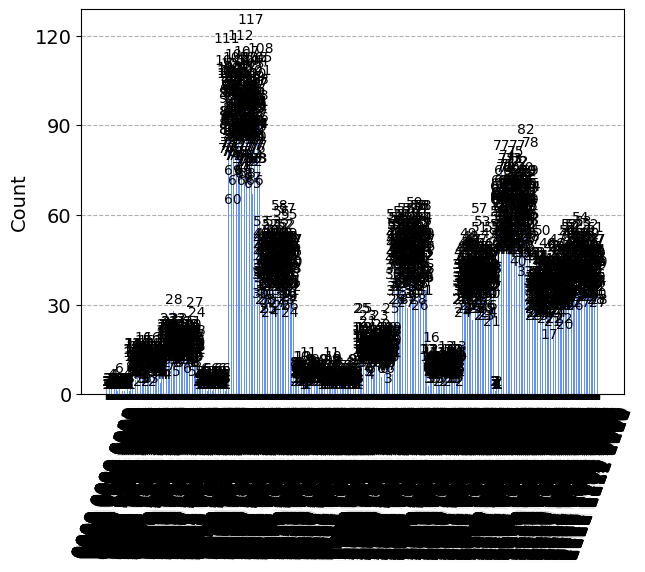

In [66]:
result = AerSimulator(enable_truncation=False,shots=100000).run(qc).result()
statistics = result.get_counts(qc)
display(plot_histogram(statistics))
sorted_statistics = dict(sorted(statistics.items(), key=lambda x: x[0]))
#print(sorted_statistics)

In [67]:
basis_states = get_basis_states(num_qubits=num_qubits)

sorted_statistics2 = {}
for basis in basis_states:
    # print(basis)
    # print(sum([value for key,value in sorted_statistics.items() if key[0:4]=='0000']))
    sorted_statistics2[basis] = sum([value for key,value in sorted_statistics.items() if key[0:4]==basis])

#sorted_statistics2

In [68]:
amplitudes = np.array(list(dict(sorted_statistics2).values()))
probabilities = amplitudes/np.sum(amplitudes)
decoded_result = np.sqrt(probabilities)
decoded_result = decoded_result*(rms)*img_max
decoded_result = decoded_result.reshape(modular_image.shape)
#print(decoded_img)
decoded_result = np.round(decoded_result)
decoded_result = decoded_result.astype(int)
# print(decoded_result/max(decoded_result))
# print(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([], dtype=int64), array([], dtype=int64))
(array([1]), array([1]))
(array([], dtype=int64), array([], dtype=int64))


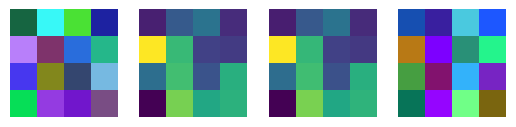

In [69]:
reconstructed_image = classical_decode(decoded_result, M=M, N=N)
#reconstructed_image

fig, axs = plt.subplots(1, 4)
axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(modular_image/np.max(image))
axs[1].axis('off')
axs[2].imshow(decoded_result/np.max(decoded_result))
axs[2].axis('off')
axs[3].imshow(reconstructed_image)
axs[3].axis('off')
plt.subplots_adjust(wspace=0.2)
plt.show()

We see that modular and decoded images are almost the same after the Teleportation. However, the initial and final images, which were expected to be the same, slightly differ in their intensities.
Intensities are directly related to amplitudes of the Image. We noted that the amplitudes before and after decoding slightly differ, and this offshoots the intensities after modular arithmetic decoding. Suppose the base M=5. Eventhough 6 and 7 are close, 6mod5 != 7mod5. This makes the pixel intensities very different.
We suppose, it is all due to the nature of Quantum Randomness, Noise and Rounding Errors. While executing QC and obtaining probabilities, we expect ideal case, where amplitudes will be exactly the same before and after decoding. However, it is still a big challenge. The solution may lay under the application of QEC/QEM techniques, under the change of encoding/decoding approaches. 


Eventhough dynamic circuit was used, comparison with a static could not be attempted in time. As a result no advantage was direcly reported.

Benjamin Sogodam Atadana
Murat Teksoz


## References
1. https://github.com/quantumcoalition/qrise2024-ibm-challenge
2. https://arxiv.org/pdf/2203.01831.pdf
3. https://arxiv.org/pdf/1801.01465.pdf
4. https://www.columbia.edu/~ask2262/CourseProjects/Kudinoor_n-QubitQuantumTeleportationProtocol.pdf

